In [45]:
!python -V

Python 3.9.18


In [46]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
# import pyarrow.parquet as pq
import requests

import mlflow
import mlflow.xgboost

# Initialize MLflow's autologging feature
mlflow.xgboost.autolog()

2024/01/21 07:57:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


In [71]:

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='_distutils_hack')
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost.core')



In [48]:
mlflow.set_tracking_uri("sqlite:///nyc_ride_duration.db")
mlflow.set_experiment("ride_duration")

<Experiment: artifact_location='/home/ramcharansatyasaitejapolisetti/MachineLearning/mlops/mlflow_project/mlruns/1', creation_time=1705772086651, experiment_id='1', last_update_time=1705772086651, lifecycle_stage='active', name='ride_duration', tags={}>

In [49]:
def read_dataframe(url):
    # url = "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet"
    response = requests.get(url)
    file_path = url.split("/")[-1]
    # "green_tripdata_2023-10.parquet"

    with open(file_path, "wb") as file:
        file.write(response.content)
    df = pd.read_parquet(file_path)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [50]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-10.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-11.parquet")

In [51]:
# df_train['categorical'] = df_train[['PULocationID', 'DOLocationID']]
# df_val['PU_DO'] = df_val[['PULocationID', 'DOLocationID']]
# df[categorical] = df[categorical].astype('str')

In [52]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df_train[categorical] = df_train[categorical].astype('str')
df_val[categorical] = df_val[categorical].astype('str')

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [53]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values


In [54]:
type(y_val)

numpy.ndarray

In [55]:
lr = LinearRegression()
lr.fit(X_train, y_train)
mlflow.sklearn.log_model(lr, "model")
y_pred = lr.predict(X_val)
mlflow.log_metric("rmse", np.sqrt(mean_squared_error(y_val, y_pred)))
np.sqrt(mean_squared_error(y_val, y_pred))


2024/01/21 07:57:47 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /home/ramcharansatyasaitejapolisetti/MachineLearning/mlops/mlflow_project/mlruns/1/bac9eae5d0c847d99ac9e3bcb1c1ffaa/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


7.985611973845232

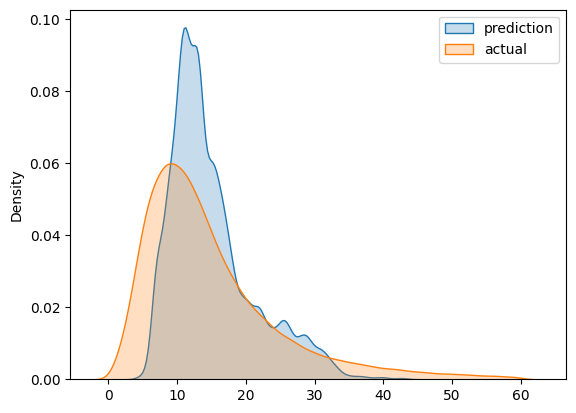

In [56]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [57]:
with open('model/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [58]:


rg = Ridge()
rg.fit(X_train, y_train)
mlflow.sklearn.log_model(rg, "model")
mlflow.log_metric("rmse", np.sqrt(mean_squared_error(y_val, y_pred)))
y_pred = rg.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))


2024/01/21 07:57:50 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /home/ramcharansatyasaitejapolisetti/MachineLearning/mlops/mlflow_project/mlruns/1/bac9eae5d0c847d99ac9e3bcb1c1ffaa/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


7.983225977862511

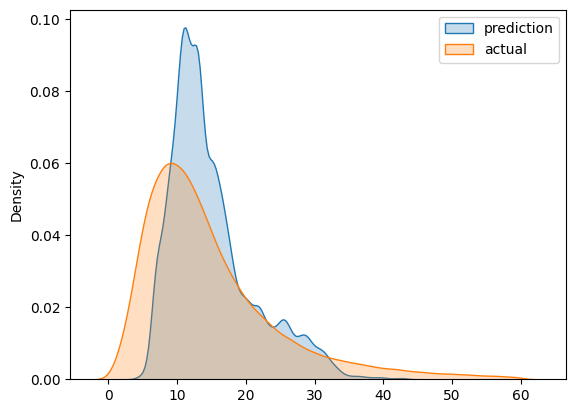

In [59]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [60]:
with open('model/ridge.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)

In [61]:
mlflow.end_run()  # End the current run
with mlflow.start_run():
    mlflow.set_tag('model', 'Lasso')
    mlflow.set_tag('version', 'v1')
    mlflow.set_tag('developer', 'ram_polisetti')

    alpha = 0.01
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)
    y_pred = ls.predict(X_val)
    
    mlflow.log_param('alpha', 0.01)
    mlflow.log_param('train_data_path', 'green_tripdata_2023-10.parquet')
    mlflow.log_param('val_data_path', 'green_tripdata_2023-11.parquet')
    mlflow.log_metric('rmse', np.sqrt(mean_squared_error(y_val, y_pred)))
    mlflow.sklearn.log_model(ls, 'model')
    

    np.sqrt(mean_squared_error(y_val, y_pred))

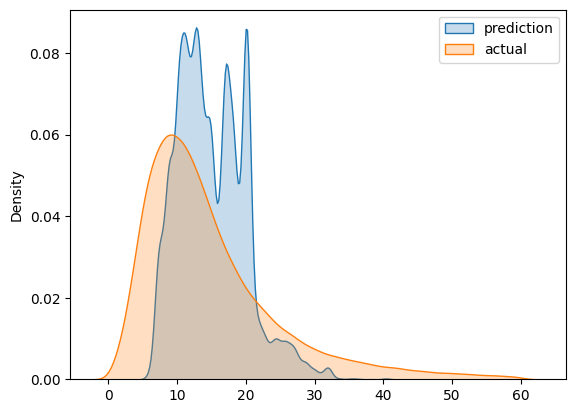

In [62]:
sns.kdeplot(y_pred, label='prediction', fill=True)
sns.kdeplot(y_val, label='actual', fill=True)

plt.legend()
plt.show()

In [63]:
with open('model/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, ls), f_out)

## Hyper Parameter Optimization

In [64]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope


In [65]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'XGBoost')
        for key, value in params.items():
            mlflow.log_param(key, value)
        mlflow.set_tag('develper', 'ram_polisetti')

        booster = xgb.train(params, 
                            dtrain = train, 
                            num_boost_round=1000,
                            evals=[(valid, 'validation')], 
                            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        # mlflow.log_param('train_data_path', 'green_tripdata_2023-10.parquet')
        # mlflow.log_param('val_data_path', 'green_tripdata_2023-11.parquet')
        mlflow.log_metric('rmse', rmse)
        mlflow.sklearn.log_model(ls, 'model')
        
    return {'loss': rmse, 'status': STATUS_OK}
        

In [66]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

In [67]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:7.65237                           
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:57:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.56658                           
[2]	validation-rmse:6.09404                           
[3]	validation-rmse:5.89018                           
[4]	validation-rmse:5.80277                           
[5]	validation-rmse:5.76269                           
[6]	validation-rmse:5.74428                           
[7]	validation-rmse:5.73037                           
[8]	validation-rmse:5.71802                           
[9]	validation-rmse:5.70250                           
[10]	validation-rmse:5.69624                          
[11]	validation-rmse:5.68699                          
[12]	validation-rmse:5.68297                          
[13]	validation-rmse:5.68340                          
[14]	validation-rmse:5.68119                          
[15]	validation-rmse:5.67535                          
[16]	validation-rmse:5.67544                          
[17]	validation-rmse:5.67407                          
[18]	validation-rmse:5.67647                          
[19]	valid

2024/01/21 07:58:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



  2%|▏         | 1/50 [00:09<07:43,  9.45s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.37548                                                    
[1]	validation-rmse:7.36254                                                    
[2]	validation-rmse:6.71077                                                    
[3]	validation-rmse:6.30489                                                    
[4]	validation-rmse:6.06384                                                    
[5]	validation-rmse:5.91826                                                    
[6]	validation-rmse:5.83089                                                    
[7]	validation-rmse:5.78218                                                    
[8]	validation-rmse:5.75518                                                    
[9]	validation-rmse:5.73819                                                    
[10]	validation-rmse:5.72846                                                   
[11]	validation-rmse:5.71890                                                   
[12]	validation-rmse:5.70975            

2024/01/21 07:58:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



  4%|▍         | 2/50 [00:20<08:14, 10.31s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.00342                                                    
[1]	validation-rmse:6.10956                                                    
[2]	validation-rmse:5.87556                                                    
[3]	validation-rmse:5.81980                                                    
[4]	validation-rmse:5.80981                                                    
[5]	validation-rmse:5.80566                                                    
[6]	validation-rmse:5.81086                                                    
[7]	validation-rmse:5.81525                                                    
[8]	validation-rmse:5.81784                                                    
[9]	validation-rmse:5.82286                                                    
[10]	validation-rmse:5.83495                                                   
[11]	validation-rmse:5.83731                                                   
[12]	validation-rmse:5.83711            

2024/01/21 07:58:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



  6%|▌         | 3/50 [00:30<07:57, 10.16s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.10867                                                    
[1]	validation-rmse:8.46204                                                    
[2]	validation-rmse:7.92402                                                    
[3]	validation-rmse:7.48005                                                    
[4]	validation-rmse:7.12039                                                    
[5]	validation-rmse:6.83398                                                    
[6]	validation-rmse:6.60555                                                    
[7]	validation-rmse:6.42584                                                    
[8]	validation-rmse:6.28730                                                    
[9]	validation-rmse:6.17562                                                    
[10]	validation-rmse:6.08921                                                   
[11]	validation-rmse:6.02389                                                   
[12]	validation-rmse:5.97756            

2024/01/21 07:58:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:37] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:7.26024                                                    
[1]	validation-rmse:6.26470                                                    
  8%|▊         | 4/50 [00:46<09:32, 12.45s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.92535                                                    
[3]	validation-rmse:5.80943                                                    
[4]	validation-rmse:5.77081                                                    
[5]	validation-rmse:5.75650                                                    
[6]	validation-rmse:5.73231                                                    
[7]	validation-rmse:5.71519                                                    
[8]	validation-rmse:5.69987                                                    
[9]	validation-rmse:5.68664                                                    
[10]	validation-rmse:5.68662                                                   
[11]	validation-rmse:5.68525                                                   
[12]	validation-rmse:5.68505                                                   
[13]	validation-rmse:5.68410                                                   
[14]	validation-rmse:5.67729            

2024/01/21 07:58:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:47] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 10%|█         | 5/50 [00:56<08:39, 11.55s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:58:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.38945                                                    
[1]	validation-rmse:8.94260                                                    
[2]	validation-rmse:8.54488                                                    
[3]	validation-rmse:8.19063                                                    
[4]	validation-rmse:7.87749                                                    
[5]	validation-rmse:7.59960                                                    
[6]	validation-rmse:7.35678                                                    
[7]	validation-rmse:7.13931                                                    
[8]	validation-rmse:6.95183                                                    
[9]	validation-rmse:6.78679                                                    
[10]	validation-rmse:6.64304                                                   
[11]	validation-rmse:6.51840                                                   
[12]	validation-rmse:6.41104            

2024/01/21 07:59:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 12%|█▏        | 6/50 [01:13<09:58, 13.59s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.79079                                                    
[1]	validation-rmse:7.95387                                                    
[2]	validation-rmse:7.32136                                                    
[3]	validation-rmse:6.85359                                                    
[4]	validation-rmse:6.51811                                                    
[5]	validation-rmse:6.27752                                                    
[6]	validation-rmse:6.10749                                                    
[7]	validation-rmse:5.99018                                                    
[8]	validation-rmse:5.90800                                                    
[9]	validation-rmse:5.85371                                                    
[10]	validation-rmse:5.82152                                                   
[11]	validation-rmse:5.79754                                                   
[12]	validation-rmse:5.78262            

2024/01/21 07:59:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 14%|█▍        | 7/50 [01:25<09:17, 12.97s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.54692                                                    
[1]	validation-rmse:6.09961                                                    
[2]	validation-rmse:6.07090                                                    
[3]	validation-rmse:6.08058                                                    
[4]	validation-rmse:6.10996                                                    
[5]	validation-rmse:6.12103                                                    
[6]	validation-rmse:6.13092                                                    
[7]	validation-rmse:6.15019                                                    
[8]	validation-rmse:6.15373                                                    
[9]	validation-rmse:6.15669                                                    
[10]	validation-rmse:6.16455                                                   
[11]	validation-rmse:6.17485                                                   
[12]	validation-rmse:6.18068            

2024/01/21 07:59:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:29] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 16%|█▌        | 8/50 [01:38<09:08, 13.06s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.83442                                                    
[1]	validation-rmse:8.01882                                                    
[2]	validation-rmse:7.39734                                                    
[3]	validation-rmse:6.93018                                                    
[4]	validation-rmse:6.58377                                                    
[5]	validation-rmse:6.33228                                                    
[6]	validation-rmse:6.15098                                                    
[7]	validation-rmse:6.01981                                                    
[8]	validation-rmse:5.92707                                                    
[9]	validation-rmse:5.86135                                                    
[10]	validation-rmse:5.81735                                                   
[11]	validation-rmse:5.78499                                                   
[12]	validation-rmse:5.76579            

2024/01/21 07:59:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:6.95305                                                    
[1]	validation-rmse:6.19795                                                    
[2]	validation-rmse:5.99202                                                    
[3]	validation-rmse:5.92101                                                    
[4]	validation-rmse:5.89621                                                    
[5]	validation-rmse:5.87510                                                    
[6]	validation-rmse:5.86045                                                    
[7]	validation-rmse:5.84750                                                    
[8]	validation-rmse:5.84263                                                    
[9]	validation-rmse:5.83629                                                    
[10]	validation-rmse:5.81693                                                   
[11]	validation-rmse:5.80993                                                   
 18%|█▊        | 9/50 [01:53<09:05, 13.3

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[12]	validation-rmse:5.80486                                                   
[13]	validation-rmse:5.79605                                                   
[14]	validation-rmse:5.79344                                                   
[15]	validation-rmse:5.79157                                                   
[16]	validation-rmse:5.78952                                                   
[17]	validation-rmse:5.78408                                                   
[18]	validation-rmse:5.77273                                                   
[19]	validation-rmse:5.77427                                                   
[20]	validation-rmse:5.77248                                                   
[21]	validation-rmse:5.77038                                                   
[22]	validation-rmse:5.76635                                                   
[23]	validation-rmse:5.76347                                                   
[24]	validation-rmse:5.76013            

2024/01/21 07:59:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:7.25198                                                     
[1]	validation-rmse:6.36401                                                     
[2]	validation-rmse:6.07492                                                     
[3]	validation-rmse:5.96099                                                     
[4]	validation-rmse:5.91538                                                     
[5]	validation-rmse:5.89839                                                     
[6]	validation-rmse:5.88004                                                     
[7]	validation-rmse:5.86763                                                     
[8]	validation-rmse:5.86629                                                     
[9]	validation-rmse:5.84913                                                     
[10]	validation-rmse:5.84472                                                    
 20%|██        | 10/50 [02:03<08:08, 12.22s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [07:59:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[11]	validation-rmse:5.83903                                                    
[12]	validation-rmse:5.81958                                                    
[13]	validation-rmse:5.81432                                                    
[14]	validation-rmse:5.81191                                                    
[15]	validation-rmse:5.80339                                                    
[16]	validation-rmse:5.79875                                                    
[17]	validation-rmse:5.79660                                                    
[18]	validation-rmse:5.79444                                                    
[19]	validation-rmse:5.78639                                                    
[20]	validation-rmse:5.78465                                                    
[21]	validation-rmse:5.77487                                                    
[22]	validation-rmse:5.77305                                                    
[23]	validation-rmse:5.76486

2024/01/21 08:00:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:00:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 22%|██▏       | 11/50 [02:12<07:29, 11.52s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:00:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.37123                                                     
[1]	validation-rmse:8.91032                                                     
[2]	validation-rmse:8.49977                                                     
[3]	validation-rmse:8.13549                                                     
[4]	validation-rmse:7.81309                                                     
[5]	validation-rmse:7.52789                                                     
[6]	validation-rmse:7.27782                                                     
[7]	validation-rmse:7.05910                                                     
[8]	validation-rmse:6.86754                                                     
[9]	validation-rmse:6.70219                                                     
[10]	validation-rmse:6.55968                                                    
[11]	validation-rmse:6.43425                                                    
[12]	validation-rmse:6.32869

2024/01/21 08:00:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:00:19] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.32877                                                     
 24%|██▍       | 12/50 [02:29<08:20, 13.17s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:00:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.83490                                                     
[2]	validation-rmse:8.40003                                                     
[3]	validation-rmse:8.01838                                                     
[4]	validation-rmse:7.68575                                                     
[5]	validation-rmse:7.39467                                                     
[6]	validation-rmse:7.14400                                                     
[7]	validation-rmse:6.92751                                                     
[8]	validation-rmse:6.74091                                                     
[9]	validation-rmse:6.58188                                                     
[10]	validation-rmse:6.44619                                                    
[11]	validation-rmse:6.33129                                                    
[12]	validation-rmse:6.23489                                                    
[13]	validation-rmse:6.15241

2024/01/21 08:00:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:00:36] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 26%|██▌       | 13/50 [02:46<08:50, 14.33s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:00:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98740                                                     
[1]	validation-rmse:8.26573                                                     
[2]	validation-rmse:7.69191                                                     
[3]	validation-rmse:7.24859                                                     
[4]	validation-rmse:6.90569                                                     
[5]	validation-rmse:6.64338                                                     
[6]	validation-rmse:6.44546                                                     
[7]	validation-rmse:6.29796                                                     
[8]	validation-rmse:6.18893                                                     
[9]	validation-rmse:6.11651                                                     
[10]	validation-rmse:6.05936                                                    
[11]	validation-rmse:6.01969                                                    
[12]	validation-rmse:5.99176

2024/01/21 08:00:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:00:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:8.33523                                                     
 28%|██▊       | 14/50 [03:04<09:10, 15.28s/trial, best loss: 5.681391632947356]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:00:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.31250                                                     
[2]	validation-rmse:6.67429                                                     
[3]	validation-rmse:6.28695                                                     
[4]	validation-rmse:6.05793                                                     
[5]	validation-rmse:5.91747                                                     
[6]	validation-rmse:5.83965                                                     
[7]	validation-rmse:5.79411                                                     
[8]	validation-rmse:5.76314                                                     
[9]	validation-rmse:5.74311                                                     
[10]	validation-rmse:5.73208                                                    
[11]	validation-rmse:5.72228                                                    
[12]	validation-rmse:5.71025                                                    
[13]	validation-rmse:5.70507

2024/01/21 08:01:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:01:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.43245                                                     
[1]	validation-rmse:9.02394                                                     
[2]	validation-rmse:8.65611                                                     
[3]	validation-rmse:8.32842                                                     
[4]	validation-rmse:8.03544                                                     
[5]	validation-rmse:7.77719                                                     
[6]	validation-rmse:7.54326                                                     
[7]	validation-rmse:7.33973                                                     
 30%|███       | 15/50 [03:14<07:57, 13.63s/trial, best loss: 5.667667096645581]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:01:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:7.15805                                                     
[9]	validation-rmse:7.00059                                                     
[10]	validation-rmse:6.85872                                                    
[11]	validation-rmse:6.73331                                                    
[12]	validation-rmse:6.62504                                                    
[13]	validation-rmse:6.52867                                                    
[14]	validation-rmse:6.44262                                                    
[15]	validation-rmse:6.36974                                                    
[16]	validation-rmse:6.30621                                                    
[17]	validation-rmse:6.24891                                                    
[18]	validation-rmse:6.19839                                                    
[19]	validation-rmse:6.15614                                                    
[20]	validation-rmse:6.11697

2024/01/21 08:01:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:01:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 32%|███▏      | 16/50 [03:31<08:29, 15.00s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:01:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.54520                                                     
[1]	validation-rmse:7.59171                                                     
[2]	validation-rmse:6.93872                                                     
[3]	validation-rmse:6.49675                                                     
[4]	validation-rmse:6.21224                                                     
[5]	validation-rmse:6.02942                                                     
[6]	validation-rmse:5.91021                                                     
[7]	validation-rmse:5.83548                                                     
[8]	validation-rmse:5.79120                                                     
[9]	validation-rmse:5.76583                                                     
[10]	validation-rmse:5.75220                                                    
[11]	validation-rmse:5.74369                                                    
[12]	validation-rmse:5.73841

2024/01/21 08:01:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:01:34] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 34%|███▍      | 17/50 [03:43<07:45, 14.09s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:01:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.07422                                                     
[1]	validation-rmse:8.40066                                                     
[2]	validation-rmse:7.85074                                                     
[3]	validation-rmse:7.40749                                                     
[4]	validation-rmse:7.04734                                                     
[5]	validation-rmse:6.76115                                                     
[6]	validation-rmse:6.53516                                                     
[7]	validation-rmse:6.36015                                                     
[8]	validation-rmse:6.22512                                                     
[9]	validation-rmse:6.12187                                                     
[10]	validation-rmse:6.04147                                                    
[11]	validation-rmse:5.98152                                                    
[12]	validation-rmse:5.93768

2024/01/21 08:01:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:01:49] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 36%|███▌      | 18/50 [03:58<07:41, 14.43s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:01:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.68894                                                     
[1]	validation-rmse:5.97074                                                     
[2]	validation-rmse:5.85031                                                     
[3]	validation-rmse:5.84267                                                     
[4]	validation-rmse:5.84214                                                     
[5]	validation-rmse:5.86048                                                     
[6]	validation-rmse:5.86489                                                     
[7]	validation-rmse:5.87369                                                     
[8]	validation-rmse:5.87307                                                     
[9]	validation-rmse:5.88244                                                     
[10]	validation-rmse:5.89036                                                    
[11]	validation-rmse:5.89148                                                    
[12]	validation-rmse:5.90004

2024/01/21 08:02:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:00] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 38%|███▊      | 19/50 [04:09<06:48, 13.17s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.44398                                                     
[1]	validation-rmse:7.45900                                                     
[2]	validation-rmse:6.82380                                                     
[3]	validation-rmse:6.41616                                                     
[4]	validation-rmse:6.16258                                                     
[5]	validation-rmse:6.01300                                                     
[6]	validation-rmse:5.92485                                                     
[7]	validation-rmse:5.87729                                                     
[8]	validation-rmse:5.86330                                                     
[9]	validation-rmse:5.84930                                                     
[10]	validation-rmse:5.84901                                                    
[11]	validation-rmse:5.84617                                                    
[12]	validation-rmse:5.84539

2024/01/21 08:02:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:12] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 40%|████      | 20/50 [04:20<06:23, 12.77s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.05058                                                     
[1]	validation-rmse:6.01134                                                     
[2]	validation-rmse:6.00542                                                     
[3]	validation-rmse:6.01981                                                     
[4]	validation-rmse:6.01097                                                     
[5]	validation-rmse:6.02023                                                     
[6]	validation-rmse:6.01621                                                     
[7]	validation-rmse:6.02870                                                     
[8]	validation-rmse:6.04698                                                     
[9]	validation-rmse:6.05366                                                     
[10]	validation-rmse:6.07869                                                    
[11]	validation-rmse:6.10638                                                    
[12]	validation-rmse:6.11546

2024/01/21 08:02:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:21] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:8.24510                                                     
[1]	validation-rmse:7.20872                                                     
 42%|████▏     | 21/50 [04:30<05:34, 11.54s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.58062                                                     
[3]	validation-rmse:6.20843                                                     
[4]	validation-rmse:6.00244                                                     
[5]	validation-rmse:5.88308                                                     
[6]	validation-rmse:5.81202                                                     
[7]	validation-rmse:5.77374                                                     
[8]	validation-rmse:5.74461                                                     
[9]	validation-rmse:5.72615                                                     
[10]	validation-rmse:5.71011                                                    
[11]	validation-rmse:5.70019                                                    
[12]	validation-rmse:5.69320                                                    
[13]	validation-rmse:5.68839                                                    
[14]	validation-rmse:5.68447

2024/01/21 08:02:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:7.81586                                                     
 44%|████▍     | 22/50 [04:39<05:05, 10.91s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.74443                                                     
[2]	validation-rmse:6.21060                                                     
[3]	validation-rmse:5.97624                                                     
[4]	validation-rmse:5.86956                                                     
[5]	validation-rmse:5.81102                                                     
[6]	validation-rmse:5.78640                                                     
[7]	validation-rmse:5.76583                                                     
[8]	validation-rmse:5.75757                                                     
[9]	validation-rmse:5.74738                                                     
[10]	validation-rmse:5.73761                                                    
[11]	validation-rmse:5.73393                                                    
[12]	validation-rmse:5.73071                                                    
[13]	validation-rmse:5.72871

2024/01/21 08:02:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:40] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.58704                                                     
[1]	validation-rmse:9.30783                                                     
[2]	validation-rmse:9.04924                                                     
[3]	validation-rmse:8.80928                                                     
[4]	validation-rmse:8.58939                                                     
[5]	validation-rmse:8.38430                                                     
[6]	validation-rmse:8.19690                                                     
[7]	validation-rmse:8.02232                                                     
[8]	validation-rmse:7.86369                                                     
[9]	validation-rmse:7.71579                                                     
[10]	validation-rmse:7.57976                                                    
[11]	validation-rmse:7.45585                                                    
[12]	validation-rmse:7.34293

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:02:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[17]	validation-rmse:6.90322                                                    
[18]	validation-rmse:6.83640                                                    
[19]	validation-rmse:6.77549                                                    
[20]	validation-rmse:6.72104                                                    
[21]	validation-rmse:6.66933                                                    
[22]	validation-rmse:6.62346                                                    
[23]	validation-rmse:6.58067                                                    
[24]	validation-rmse:6.54323                                                    
[25]	validation-rmse:6.50715                                                    
[26]	validation-rmse:6.47525                                                    
[27]	validation-rmse:6.44558                                                    
[28]	validation-rmse:6.41811                                                    
[29]	validation-rmse:6.39339

2024/01/21 08:03:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:03] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 48%|████▊     | 24/50 [05:12<06:16, 14.48s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.54768                                                     
[1]	validation-rmse:9.23147                                                     
[2]	validation-rmse:8.93769                                                     
[3]	validation-rmse:8.66509                                                     
[4]	validation-rmse:8.41291                                                     
[5]	validation-rmse:8.17936                                                     
[6]	validation-rmse:7.96315                                                     
[7]	validation-rmse:7.76431                                                     
[8]	validation-rmse:7.58050                                                     
[9]	validation-rmse:7.41047                                                     
[10]	validation-rmse:7.25542                                                    
[11]	validation-rmse:7.11223                                                    
[12]	validation-rmse:6.98201

2024/01/21 08:03:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:6.14391                                                     
 50%|█████     | 25/50 [05:33<06:47, 16.30s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.93078                                                     
[2]	validation-rmse:5.91951                                                     
[3]	validation-rmse:5.91692                                                     
[4]	validation-rmse:5.90381                                                     
[5]	validation-rmse:5.90138                                                     
[6]	validation-rmse:5.90966                                                     
[7]	validation-rmse:5.91782                                                     
[8]	validation-rmse:5.92528                                                     
[9]	validation-rmse:5.93733                                                     
[10]	validation-rmse:5.94885                                                    
[11]	validation-rmse:5.95488                                                    
[12]	validation-rmse:5.96849                                                    
[13]	validation-rmse:5.98658

2024/01/21 08:03:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:7.95885                                                     
[1]	validation-rmse:6.87050                                                     
 52%|█████▏    | 26/50 [05:42<05:37, 14.07s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.30412                                                     
[3]	validation-rmse:6.00888                                                     
[4]	validation-rmse:5.86276                                                     
[5]	validation-rmse:5.79255                                                     
[6]	validation-rmse:5.76353                                                     
[7]	validation-rmse:5.74557                                                     
[8]	validation-rmse:5.73247                                                     
[9]	validation-rmse:5.72723                                                     
[10]	validation-rmse:5.72590                                                    
[11]	validation-rmse:5.72609                                                    
[12]	validation-rmse:5.72671                                                    
[13]	validation-rmse:5.72508                                                    
[14]	validation-rmse:5.72331

2024/01/21 08:03:42 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:42] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.28732                                                     
[1]	validation-rmse:8.76825                                                     
[2]	validation-rmse:8.32291                                                     
[3]	validation-rmse:7.94228                                                     
[4]	validation-rmse:7.61674                                                     
[5]	validation-rmse:7.34144                                                     
[6]	validation-rmse:7.10822                                                     
[7]	validation-rmse:6.91287                                                     
[8]	validation-rmse:6.74834                                                     
[9]	validation-rmse:6.61120                                                     
[10]	validation-rmse:6.49284                                                    
 54%|█████▍    | 27/50 [05:51<04:49, 12.60s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[11]	validation-rmse:6.39546                                                    
[12]	validation-rmse:6.31652                                                    
[13]	validation-rmse:6.24803                                                    
[14]	validation-rmse:6.19176                                                    
[15]	validation-rmse:6.14545                                                    
[16]	validation-rmse:6.10586                                                    
[17]	validation-rmse:6.07171                                                    
[18]	validation-rmse:6.04442                                                    
[19]	validation-rmse:6.02116                                                    
[20]	validation-rmse:6.00229                                                    
[21]	validation-rmse:5.98399                                                    
[22]	validation-rmse:5.96996                                                    
[23]	validation-rmse:5.95627

2024/01/21 08:03:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:03:59] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.50583                                                     
[1]	validation-rmse:9.15509                                                     
[2]	validation-rmse:8.83304                                                     
[3]	validation-rmse:8.53976                                                     
 56%|█████▌    | 28/50 [06:09<05:08, 14.02s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:04:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:8.27196                                                     
[5]	validation-rmse:8.02617                                                     
[6]	validation-rmse:7.80283                                                     
[7]	validation-rmse:7.60234                                                     
[8]	validation-rmse:7.42129                                                     
[9]	validation-rmse:7.25418                                                     
[10]	validation-rmse:7.10509                                                    
[11]	validation-rmse:6.96819                                                    
[12]	validation-rmse:6.84511                                                    
[13]	validation-rmse:6.73576                                                    
[14]	validation-rmse:6.63579                                                    
[15]	validation-rmse:6.54517                                                    
[16]	validation-rmse:6.46590

2024/01/21 08:04:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:04:14] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.25904                                                     
[1]	validation-rmse:8.71601                                                     
[2]	validation-rmse:8.24939                                                     
[3]	validation-rmse:7.85024                                                     
[4]	validation-rmse:7.51202                                                     
                                                                                

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:04:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:7.22601
[6]	validation-rmse:6.98427                                                     
[7]	validation-rmse:6.78259                                                     
[8]	validation-rmse:6.61431                                                     
[9]	validation-rmse:6.47316                                                     
[10]	validation-rmse:6.35551                                                    
[11]	validation-rmse:6.25722                                                    
[12]	validation-rmse:6.17629                                                    
[13]	validation-rmse:6.10819                                                    
[14]	validation-rmse:6.05248                                                    
[15]	validation-rmse:6.00707                                                    
[16]	validation-rmse:5.96804                                                    
[17]	validation-rmse:5.93754                                                    


2024/01/21 08:04:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:04:30] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.31962                                                     
[1]	validation-rmse:8.82988                                                     
[2]	validation-rmse:8.40631                                                     
[3]	validation-rmse:8.04388                                                     
[4]	validation-rmse:7.73336                                                     
[5]	validation-rmse:7.46834                                                     
[6]	validation-rmse:7.24411                                                     
[7]	validation-rmse:7.05560                                                     
[8]	validation-rmse:6.89759                                                     
[9]	validation-rmse:6.76548                                                     
[10]	validation-rmse:6.65295                                                    
[11]	validation-rmse:6.55826                                                    
[12]	validation-rmse:6.48014

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:04:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[14]	validation-rmse:6.35690                                                    
[15]	validation-rmse:6.30999                                                    
[16]	validation-rmse:6.27024                                                    
[17]	validation-rmse:6.23736                                                    
[18]	validation-rmse:6.20763                                                    
[19]	validation-rmse:6.18343                                                    
[20]	validation-rmse:6.16213                                                    
[21]	validation-rmse:6.14312                                                    
[22]	validation-rmse:6.12664                                                    
[23]	validation-rmse:6.11443                                                    
[24]	validation-rmse:6.10147                                                    
[25]	validation-rmse:6.09099                                                    
[26]	validation-rmse:6.08130

2024/01/21 08:04:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:04:54] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.49828                                                     
[1]	validation-rmse:9.14050                                                     
[2]	validation-rmse:8.81312                                                     
[3]	validation-rmse:8.51366                                                     


/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:04:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:8.24092
[5]	validation-rmse:7.99272                                                     
[6]	validation-rmse:7.76652                                                     
[7]	validation-rmse:7.56299                                                     
[8]	validation-rmse:7.37805                                                     
[9]	validation-rmse:7.21123                                                     
[10]	validation-rmse:7.06105                                                    
[11]	validation-rmse:6.92675                                                    
[12]	validation-rmse:6.80449                                                    
[13]	validation-rmse:6.69468                                                    
[14]	validation-rmse:6.59720                                                    
[15]	validation-rmse:6.50896                                                    
[16]	validation-rmse:6.42988                                                    


2024/01/21 08:05:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:05:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 64%|██████▍   | 32/50 [07:23<05:25, 18.10s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:05:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.43958                                                     
[1]	validation-rmse:9.03451                                                     
[2]	validation-rmse:8.66582                                                     
[3]	validation-rmse:8.33589                                                     
[4]	validation-rmse:8.03776                                                     
[5]	validation-rmse:7.77153                                                     
[6]	validation-rmse:7.53041                                                     
[7]	validation-rmse:7.31767                                                     
[8]	validation-rmse:7.12635                                                     
[9]	validation-rmse:6.95835                                                     
[10]	validation-rmse:6.80673                                                    
[11]	validation-rmse:6.67428                                                    
[12]	validation-rmse:6.55460

2024/01/21 08:05:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:05:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:8.87618                                                     
[1]	validation-rmse:8.09679                                                     
[2]	validation-rmse:7.50044                                                     
[3]	validation-rmse:7.05589                                                     
[4]	validation-rmse:6.73046                                                     
[5]	validation-rmse:6.48852                                                     
[6]	validation-rmse:6.31018                                                     
                                                                                

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:05:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:6.17668
[8]	validation-rmse:6.08521                                                     
[9]	validation-rmse:6.01483                                                     
[10]	validation-rmse:5.96196                                                    
[11]	validation-rmse:5.92488                                                    
[12]	validation-rmse:5.89505                                                    
[13]	validation-rmse:5.87473                                                    
[14]	validation-rmse:5.85632                                                    
[15]	validation-rmse:5.84301                                                    
[16]	validation-rmse:5.83088                                                    
[17]	validation-rmse:5.81984                                                    
[18]	validation-rmse:5.81258                                                    
[19]	validation-rmse:5.80349                                                    


2024/01/21 08:05:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:05:39] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.22938                                                     
[1]	validation-rmse:8.66381                                                     
 68%|██████▊   | 34/50 [07:49<04:03, 15.24s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:05:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.17880                                                     
[3]	validation-rmse:7.77247                                                     
[4]	validation-rmse:7.42301                                                     
[5]	validation-rmse:7.13596                                                     
[6]	validation-rmse:6.89444                                                     
[7]	validation-rmse:6.69026                                                     
[8]	validation-rmse:6.52049                                                     
[9]	validation-rmse:6.38473                                                     
[10]	validation-rmse:6.26788                                                    
[11]	validation-rmse:6.17355                                                    
[12]	validation-rmse:6.09615                                                    
[13]	validation-rmse:6.03436                                                    
[14]	validation-rmse:5.98177

2024/01/21 08:05:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:05:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.12220                                                     
[1]	validation-rmse:8.49836                                                     
[2]	validation-rmse:8.00143                                                     
[3]	validation-rmse:7.59887                                                     
[4]	validation-rmse:7.28075                                                     
[5]	validation-rmse:7.03284                                                     
[6]	validation-rmse:6.83826                                                     
[7]	validation-rmse:6.68396                                                     
[8]	validation-rmse:6.56668                                                     
[9]	validation-rmse:6.47458                                                     
[10]	validation-rmse:6.39746                                                    
[11]	validation-rmse:6.34346                                                    
[12]	validation-rmse:6.29669

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:05:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[15]	validation-rmse:6.20429                                                    
[16]	validation-rmse:6.18742                                                    
[17]	validation-rmse:6.16949                                                    
[18]	validation-rmse:6.15588                                                    
[19]	validation-rmse:6.14409                                                    
[20]	validation-rmse:6.13265                                                    
[21]	validation-rmse:6.12339                                                    
[22]	validation-rmse:6.11401                                                    
[23]	validation-rmse:6.10506                                                    
[24]	validation-rmse:6.09741                                                    
[25]	validation-rmse:6.09049                                                    
[26]	validation-rmse:6.08139                                                    
[27]	validation-rmse:6.07569

2024/01/21 08:06:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:06:15] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.32744                                                     
[1]	validation-rmse:8.83401                                                     
 72%|███████▏  | 36/50 [08:25<04:00, 17.17s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:06:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.40096                                                     
[3]	validation-rmse:8.02155                                                     
[4]	validation-rmse:7.69302                                                     
[5]	validation-rmse:7.40671                                                     
[6]	validation-rmse:7.15901                                                     
[7]	validation-rmse:6.94695                                                     
[8]	validation-rmse:6.76529                                                     
[9]	validation-rmse:6.60944                                                     
[10]	validation-rmse:6.47452                                                    
[11]	validation-rmse:6.35955                                                    
[12]	validation-rmse:6.26226                                                    
[13]	validation-rmse:6.18018                                                    
[14]	validation-rmse:6.11087

2024/01/21 08:06:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:06:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 74%|███████▍  | 37/50 [08:43<03:49, 17.63s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:06:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.65107                                                     
[1]	validation-rmse:7.74872                                                     
[2]	validation-rmse:7.09741                                                     
[3]	validation-rmse:6.65180                                                     
[4]	validation-rmse:6.34412                                                     
[5]	validation-rmse:6.13794                                                     
[6]	validation-rmse:5.99923                                                     
[7]	validation-rmse:5.90694                                                     
[8]	validation-rmse:5.84848                                                     
[9]	validation-rmse:5.80616                                                     
[10]	validation-rmse:5.78136                                                    
[11]	validation-rmse:5.76950                                                    
[12]	validation-rmse:5.76161

2024/01/21 08:06:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:06:46] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 76%|███████▌  | 38/50 [08:54<03:10, 15.87s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:06:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.48951                                                     
[1]	validation-rmse:9.12638                                                     
[2]	validation-rmse:8.79366                                                     
[3]	validation-rmse:8.49025                                                     
[4]	validation-rmse:8.21566                                                     
[5]	validation-rmse:7.96584                                                     
[6]	validation-rmse:7.74004                                                     
[7]	validation-rmse:7.53928                                                     
[8]	validation-rmse:7.35475                                                     
[9]	validation-rmse:7.19085                                                     
[10]	validation-rmse:7.04170                                                    
[11]	validation-rmse:6.90915                                                    
[12]	validation-rmse:6.79036

2024/01/21 08:07:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:07:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.41567                                                     
[1]	validation-rmse:8.99198                                                     
[2]	validation-rmse:8.61117                                                     
 78%|███████▊  | 39/50 [09:21<03:28, 18.92s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:07:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.27018                                                     
[4]	validation-rmse:7.96587                                                     
[5]	validation-rmse:7.69486                                                     
[6]	validation-rmse:7.45534                                                     
[7]	validation-rmse:7.24187                                                     
[8]	validation-rmse:7.05389                                                     
[9]	validation-rmse:6.88856                                                     
[10]	validation-rmse:6.74255                                                    
[11]	validation-rmse:6.61563                                                    
[12]	validation-rmse:6.50416                                                    
[13]	validation-rmse:6.40713                                                    
[14]	validation-rmse:6.32100                                                    
[15]	validation-rmse:6.24644

2024/01/21 08:07:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:07:28] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 80%|████████  | 40/50 [09:38<03:06, 18.65s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:07:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92309                                                     
[1]	validation-rmse:8.15555                                                     
[2]	validation-rmse:7.55678                                                     
[3]	validation-rmse:7.09767                                                     
[4]	validation-rmse:6.75054                                                     
[5]	validation-rmse:6.48914                                                     
[6]	validation-rmse:6.29795                                                     
[7]	validation-rmse:6.15578                                                     
[8]	validation-rmse:6.05479                                                     
[9]	validation-rmse:5.98095                                                     
[10]	validation-rmse:5.93067                                                    
[11]	validation-rmse:5.89334                                                    
[12]	validation-rmse:5.87001

2024/01/21 08:07:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:07:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.19400                                                     
[1]	validation-rmse:8.61003                                                     
[2]	validation-rmse:8.12286                                                     
[3]	validation-rmse:7.71532                                                     
[4]	validation-rmse:7.38249                                                     
[5]	validation-rmse:7.10896                                                     
[6]	validation-rmse:6.88340                                                     
[7]	validation-rmse:6.70208                                                     
[8]	validation-rmse:6.55122                                                     
[9]	validation-rmse:6.42887                                                     
 82%|████████▏ | 41/50 [09:52<02:32, 17.00s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:07:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[10]	validation-rmse:6.32986                                                    
[11]	validation-rmse:6.25010                                                    
[12]	validation-rmse:6.18404                                                    
[13]	validation-rmse:6.13027                                                    
[14]	validation-rmse:6.08764                                                    
[15]	validation-rmse:6.05097                                                    
[16]	validation-rmse:6.02304                                                    
[17]	validation-rmse:5.99774                                                    
[18]	validation-rmse:5.97606                                                    
[19]	validation-rmse:5.95775                                                    
[20]	validation-rmse:5.94378                                                    
[21]	validation-rmse:5.92947                                                    
[22]	validation-rmse:5.91793

2024/01/21 08:07:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:07:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.17280                                                     
[1]	validation-rmse:8.56713                                                     
[2]	validation-rmse:8.05840                                                     
 84%|████████▍ | 42/50 [10:08<02:11, 16.48s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.63633                                                     
[4]	validation-rmse:7.27998                                                     
[5]	validation-rmse:6.98996                                                     
[6]	validation-rmse:6.75528                                                     
[7]	validation-rmse:6.55784                                                     
[8]	validation-rmse:6.39635                                                     
[9]	validation-rmse:6.27127                                                     
[10]	validation-rmse:6.16704                                                    
[11]	validation-rmse:6.08173                                                    
[12]	validation-rmse:6.01462                                                    
[13]	validation-rmse:5.95932                                                    
[14]	validation-rmse:5.91743                                                    
[15]	validation-rmse:5.88169

2024/01/21 08:08:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:09] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 86%|████████▌ | 43/50 [10:18<01:44, 14.96s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.09087                                                     
[1]	validation-rmse:8.43025                                                     
[2]	validation-rmse:7.89132                                                     
[3]	validation-rmse:7.45351                                                     
[4]	validation-rmse:7.10077                                                     
[5]	validation-rmse:6.81117                                                     
[6]	validation-rmse:6.58909                                                     
[7]	validation-rmse:6.40850                                                     
[8]	validation-rmse:6.27148                                                     
[9]	validation-rmse:6.16479                                                     
[10]	validation-rmse:6.08255                                                    
[11]	validation-rmse:6.01830                                                    
[12]	validation-rmse:5.96753

2024/01/21 08:08:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:23] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:8.63763                                                     
 88%|████████▊ | 44/50 [10:32<01:26, 14.42s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.72455                                                     
[2]	validation-rmse:7.07592                                                     
[3]	validation-rmse:6.61893                                                     
[4]	validation-rmse:6.31460                                                     
[5]	validation-rmse:6.10565                                                     
[6]	validation-rmse:5.97055                                                     
[7]	validation-rmse:5.87765                                                     
[8]	validation-rmse:5.81913                                                     
[9]	validation-rmse:5.77962                                                     
[10]	validation-rmse:5.75532                                                    
[11]	validation-rmse:5.73865                                                    
[12]	validation-rmse:5.72528                                                    
[13]	validation-rmse:5.71549

2024/01/21 08:08:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 90%|█████████ | 45/50 [10:42<01:05, 13.14s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.32802                                                     
[1]	validation-rmse:8.83490                                                     
[2]	validation-rmse:8.40027                                                     
[3]	validation-rmse:8.02359                                                     
[4]	validation-rmse:7.69098                                                     
[5]	validation-rmse:7.40520                                                     
[6]	validation-rmse:7.15384                                                     
[7]	validation-rmse:6.94260                                                     
[8]	validation-rmse:6.75729                                                     
[9]	validation-rmse:6.59887                                                     
[10]	validation-rmse:6.46708                                                    
[11]	validation-rmse:6.35463                                                    
[12]	validation-rmse:6.25895

2024/01/21 08:08:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:48] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 92%|█████████▏| 46/50 [10:57<00:55, 13.79s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.26819                                                     
[1]	validation-rmse:6.25594                                                     
[2]	validation-rmse:5.91271                                                     
[3]	validation-rmse:5.81282                                                     
[4]	validation-rmse:5.79969                                                     
[5]	validation-rmse:5.80589                                                     
[6]	validation-rmse:5.81725                                                     
[7]	validation-rmse:5.82356                                                     
[8]	validation-rmse:5.82562                                                     
[9]	validation-rmse:5.83027                                                     
[10]	validation-rmse:5.83882                                                    
[11]	validation-rmse:5.83806                                                    
[12]	validation-rmse:5.84021

2024/01/21 08:08:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:08:58] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.44356                                                     
[1]	validation-rmse:9.04242                                                     
[2]	validation-rmse:8.68172                                                     
[3]	validation-rmse:8.35754                                                     
[4]	validation-rmse:8.06602                                                     
[5]	validation-rmse:7.80489                                                     
 94%|█████████▍| 47/50 [11:08<00:38, 12.77s/trial, best loss: 5.616012731862577]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:09:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:7.57399                                                     
[7]	validation-rmse:7.36613                                                     
[8]	validation-rmse:7.18333                                                     
[9]	validation-rmse:7.01823                                                     
[10]	validation-rmse:6.87347                                                    
[11]	validation-rmse:6.74612                                                    
[12]	validation-rmse:6.63235                                                    
[13]	validation-rmse:6.53150                                                    
[14]	validation-rmse:6.44373                                                    
[15]	validation-rmse:6.36640                                                    
[16]	validation-rmse:6.29998                                                    
[17]	validation-rmse:6.24092                                                    
[18]	validation-rmse:6.18736

2024/01/21 08:09:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:09:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



 96%|█████████▌| 48/50 [11:26<00:28, 14.43s/trial, best loss: 5.613582141895082]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:09:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.43817                                                     
[1]	validation-rmse:9.03226                                                     
[2]	validation-rmse:8.66659                                                     
[3]	validation-rmse:8.33734                                                     
[4]	validation-rmse:8.04294                                                     
[5]	validation-rmse:7.78196                                                     
[6]	validation-rmse:7.54861                                                     
[7]	validation-rmse:7.34089                                                     
[8]	validation-rmse:7.15873                                                     
[9]	validation-rmse:6.99598                                                     
[10]	validation-rmse:6.85565                                                    
[11]	validation-rmse:6.73124                                                    
[12]	validation-rmse:6.62338

2024/01/21 08:09:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:09:43] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



[0]	validation-rmse:9.54280                                                     
 98%|█████████▊| 49/50 [11:54<00:18, 18.30s/trial, best loss: 5.613582141895082]

/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:09:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.22286                                                     
[2]	validation-rmse:8.92637                                                     
[3]	validation-rmse:8.65067                                                     
[4]	validation-rmse:8.39619                                                     
[5]	validation-rmse:8.16106                                                     
[6]	validation-rmse:7.94404                                                     
[7]	validation-rmse:7.74452                                                     
[8]	validation-rmse:7.56078                                                     
[9]	validation-rmse:7.39186                                                     
[10]	validation-rmse:7.23694                                                    
[11]	validation-rmse:7.09514                                                    
[12]	validation-rmse:6.96584                                                    
[13]	validation-rmse:6.84681

2024/01/21 08:10:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ramcharansatyasaitejapolisetti/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [08:10:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."



100%|██████████| 50/50 [12:11<00:00, 14.64s/trial, best loss: 5.613582141895082]


In [74]:


# Train your model here
params = {
    'learning_rate': 0.11648687272214116,
    'max_depth': 9,
    'min_child_weight': 9.395239457131943,
    'reg_alpha': 0.08493040947401051,
    'reg_lambda': 0.15624935230176376,
    'seed': 42
}
booster = xgb.train(params, 
                    dtrain=train, 
                    num_boost_round=1000,
                    evals=[(valid, 'validation')], 
                    early_stopping_rounds=50)

# Log preprocessor
with open('model/preprocessor.bin', 'wb') as f_out:
    pickle.dump(dv, f_out)
mlflow.log_artifact(local_path='model/preprocessor.bin', artifact_path='preprocessor')

# Log the trained model
# mlflow.xgboost.log_model(booster, artifact_path='mlflow-model')
booster.save_model("model.json")  # Save in JSON format
mlflow.log_artifact("model.json", "model")  # Log the JSON model file



# Make predictions and evaluate the model
y_pred = booster.predict(valid)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

[0]	validation-rmse:9.16820
[1]	validation-rmse:8.56559
[2]	validation-rmse:8.06593
[3]	validation-rmse:7.65317
[4]	validation-rmse:7.30997
[5]	validation-rmse:7.03459
[6]	validation-rmse:6.80890
[7]	validation-rmse:6.62937
[8]	validation-rmse:6.48242
[9]	validation-rmse:6.36405
[10]	validation-rmse:6.26980
[11]	validation-rmse:6.19300
[12]	validation-rmse:6.13098
[13]	validation-rmse:6.08046
[14]	validation-rmse:6.04114
[15]	validation-rmse:6.00620
[16]	validation-rmse:5.97872
[17]	validation-rmse:5.95742
[18]	validation-rmse:5.93861
[19]	validation-rmse:5.92222
[20]	validation-rmse:5.90808
[21]	validation-rmse:5.89687
[22]	validation-rmse:5.88586
[23]	validation-rmse:5.87929
[24]	validation-rmse:5.86874
[25]	validation-rmse:5.86133
[26]	validation-rmse:5.85515
[27]	validation-rmse:5.84943
[28]	validation-rmse:5.84481
[29]	validation-rmse:5.83855
[30]	validation-rmse:5.83487
[31]	validation-rmse:5.83055
[32]	validation-rmse:5.82731
[33]	validation-rmse:5.82220
[34]	validation-rmse:5.8

2024/01/21 08:19:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /home/ramcharansatyasaitejapolisetti/MachineLearning/mlops/mlflow_project/mlruns/1/2b7bd645049c49b49a7d988310d6d17a/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


5.609103862679161
